In [187]:
import pandas as pd
import collections
import skbio 
from skbio.diversity.alpha import shannon 
import IPython
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
vdjdb_data = pd.read_csv("vdjdb_data.csv")

In [173]:
del vdjdb_data ['Unnamed: 0']

In [174]:
vdjdb_data.head()

,Gene,CDR3,V,J,Species,MHC A,Epitope,Epitope gene
0,TRA,CAVGNNAGNMLTF,TRAV20*01,TRAJ39*01,HomoSapiens,HLA-B*44:03:08,NEGVKAAW,IE2
1,TRA,CAAKTGGGNKLTF,TRAV29/DV5*01,TRAJ10*01,HomoSapiens,HLA-B*44:03:08,NEGVKAAW,IE2
2,TRA,CAAKAGGGNKLTF,TRAV29/DV5*01,TRAJ10*01,HomoSapiens,HLA-B*44:03:08,NEGVKAAW,IE2
3,TRA,CAAITGIGGSQGNLIF,TRAV13-1*01,TRAJ42*01,HomoSapiens,HLA-B*44:03:08,NEGVKAAW,IE2
4,TRA,CAGTDGGATNKLIF,TRAV36/DV7*01,TRAJ32*01,HomoSapiens,HLA-B*44:03:08,NEGVKAAW,IE2


In [175]:
TRAJ = vdjdb_data ['J'].unique()
TRAV = vdjdb_data ['V'].unique()

In [176]:
print (TRAJ) # via deze methode gekeken hoe de data eruitzag om te splitsen

['TRAJ39*01' 'TRAJ10*01' 'TRAJ42*01' 'TRAJ32*01' 'TRAJ13*01' 'TRAJ8*01'
 'TRAJ47*01' 'TRAJ29*01' 'TRAJ17*01' 'TRAJ38*01' 'TRAJ44*01' 'TRAJ49*01'
 'TRAJ26*01' 'TRAJ34*01' 'TRAJ40*01' 'TRAJ33*01' 'TRAJ23*01' 'TRAJ57*01'
 'TRAJ43*01' 'TRAJ6*01' 'TRAJ20*01' 'TRAJ30*01' 'TRAJ48*01' 'TRAJ31*01'
 'TRAJ45*01' 'TRAJ3*01' 'TRAJ27*01' 'TRAJ36*01' 'TRAJ52*01' 'TRAJ15*01'
 'TRAJ5*01' 'TRAJ4*01' 'TRAJ50*01' 'TRAJ28*01' 'TRAJ53*01' 'TRAJ37*01'
 'TRAJ22*01' 'TRAJ41*01' 'TRAJ9*01' 'TRAJ12*01' 'TRAJ11*01' 'TRAJ46*01'
 'TRAJ54*01' 'TRAJ18*01' 'TRAJ21*01' 'TRAJ56*01' 'TRAJ7*01' 'TRAJ14*01'
 'TRAJ13*02' 'TRAJ24*02']


In [177]:
print (TRAV) 

['TRAV20*01' 'TRAV29/DV5*01' 'TRAV13-1*01' 'TRAV36/DV7*01' 'TRAV19*01'
 'TRAV8-2*01' 'TRAV27*01' 'TRAV8-6*01' 'TRAV35*01' 'TRAV9-2*01'
 'TRAV23/DV6*01' 'TRAV38-2/DV8*01' 'TRAV18*01' 'TRAV8-3*01' 'TRAV22*01'
 'TRAV13-2*01' 'TRAV21*01' 'TRAV8-4*01' 'TRAV5*01' 'TRAV12-2*01'
 'TRAV38-1*01' 'TRAV12-1*01' 'TRAV1-2*01' 'TRAV39*01' 'TRAV16*01'
 'TRAV17*01' 'TRAV10*01' 'TRAV24*01' 'TRAV41*01' 'TRAV12-3*01' 'TRAV3*01'
 'TRAV8-1*01' 'TRAV26-2*01' 'TRAV4*01' 'TRAV14/DV4*01' 'TRAV2*01'
 'TRAV30*01' 'TRAV25*01' 'TRAV26-1*01' 'TRAV1-1*01' 'TRAV34*01'
 'TRAV40*01' 'TRAV6*01' 'TRAV9-1*01' 'TRAV7*01' 'TRAV14/DV4*02'
 'TRAV8-6*02']


In [178]:
vdjdb_data = vdjdb_data[sorted(vdjdb_data.columns)]

In [179]:
vdjdb_data.head()

,CDR3,Epitope,Epitope gene,Gene,J,MHC A,Species,V
0,CAVGNNAGNMLTF,NEGVKAAW,IE2,TRA,TRAJ39*01,HLA-B*44:03:08,HomoSapiens,TRAV20*01
1,CAAKTGGGNKLTF,NEGVKAAW,IE2,TRA,TRAJ10*01,HLA-B*44:03:08,HomoSapiens,TRAV29/DV5*01
2,CAAKAGGGNKLTF,NEGVKAAW,IE2,TRA,TRAJ10*01,HLA-B*44:03:08,HomoSapiens,TRAV29/DV5*01
3,CAAITGIGGSQGNLIF,NEGVKAAW,IE2,TRA,TRAJ42*01,HLA-B*44:03:08,HomoSapiens,TRAV13-1*01
4,CAGTDGGATNKLIF,NEGVKAAW,IE2,TRA,TRAJ32*01,HLA-B*44:03:08,HomoSapiens,TRAV36/DV7*01


In [181]:
vdjdb_data.replace('TRAJ','',regex=True, inplace = True)
vdjdb_data[['J_family','J_allele']] = vdjdb_data.J.str.split ("*",expand=True)
del vdjdb_data ['J']
vdjdb_data.head()

,CDR3,Epitope,Epitope gene,Gene,MHC A,Species,V,J_family,J_allele
0,CAVGNNAGNMLTF,NEGVKAAW,IE2,TRA,HLA-B*44:03:08,HomoSapiens,TRAV20*01,39,01
1,CAAKTGGGNKLTF,NEGVKAAW,IE2,TRA,HLA-B*44:03:08,HomoSapiens,TRAV29/DV5*01,10,01
2,CAAKAGGGNKLTF,NEGVKAAW,IE2,TRA,HLA-B*44:03:08,HomoSapiens,TRAV29/DV5*01,10,01
3,CAAITGIGGSQGNLIF,NEGVKAAW,IE2,TRA,HLA-B*44:03:08,HomoSapiens,TRAV13-1*01,42,01
4,CAGTDGGATNKLIF,NEGVKAAW,IE2,TRA,HLA-B*44:03:08,HomoSapiens,TRAV36/DV7*01,32,01


In [125]:
vdjdb_data.replace('TRAV','',regex=True, inplace = True)
vdjdb_data[['V','V_allele']] = vdjdb_data.V.str.split ("*",expand=True) # eerst allele afsplitsen, komt na de *
# dan in 3 stappen de gene van de family scheiden
vdjdb_data[['V_family','V_gene_1']] = vdjdb_data.V.str.split ("-",expand=True) # eerst scheiden op -
vdjdb_data[['V_family','V_gene_2']] = vdjdb_data.V_family.str.split ("/",expand=True) # dan op /
vdjdb_data.replace(np.nan,'', regex=True )
# ten slotte de 2 gene kolommen nog mergen en de andere 2 verwijderen
vdjdb_data = vdjdb_data.assign(V_gene = vdjdb_data.V_gene_1.astype(str) + vdjdb_data.V_gene_2.astype(str))

In [129]:
vdjdb_data.replace('nan','',regex=True, inplace = True)

In [132]:
del vdjdb_data ['V']
del vdjdb_data ['V_gene_1']
del vdjdb_data ['V_gene_2']

In [134]:
vdjdb_data = vdjdb_data[sorted(vdjdb_data.columns)]
vdjdb_data.head()

,CDR3,Epitope,Epitope gene,Gene,J_allele,J_family,MHC A,Species,V_allele,V_family,V_gene
0,CAVGNNAGNMLTF,NEGVKAAW,IE2,TRA,01,39,HLA-B*44:03:08,HomoSapiens,01,20,
1,CAAKTGGGNKLTF,NEGVKAAW,IE2,TRA,01,10,HLA-B*44:03:08,HomoSapiens,01,29,DV5
2,CAAKAGGGNKLTF,NEGVKAAW,IE2,TRA,01,10,HLA-B*44:03:08,HomoSapiens,01,29,DV5
3,CAAITGIGGSQGNLIF,NEGVKAAW,IE2,TRA,01,42,HLA-B*44:03:08,HomoSapiens,01,13,1
4,CAGTDGGATNKLIF,NEGVKAAW,IE2,TRA,01,32,HLA-B*44:03:08,HomoSapiens,01,36,DV7


In [137]:
vdjdb_pos = vdjdb_data.groupby('Epitope').filter(lambda x: len(x)> 30)

In [138]:
## Data exploration
classes = vdjdb_pos['Epitope'].unique()
stats = collections.defaultdict(list)
for peptide in classes:
    pep_data = vdjdb_pos[vdjdb_pos['Epitope'] == peptide]
    
    stats['total TCRAs'].append(pep_data.shape[0])
    stats['unique CDR3'].append(len(set(pep_data['CDR3'])))
    
    cdr3_count = list(collections.Counter(pep_data['CDR3']).values())
    stats['CDR3 diversity'].append(shannon(cdr3_count))
    
    stats['unique V family'].append(len(pep_data['V_family'].unique()))
    stats['unique J family'].append(len(pep_data['J_family'].unique()))
    stats['unique V gene'].append(len(pep_data['V_gene'].unique()))
    stats['unique J allele'].append(len(pep_data['J_allele'].unique()))
    stats['unique V allele'].append(len(pep_data['V_allele'].unique()))
    v_fam_count = list(collections.Counter(pep_data['V_family']).values())
    j_fam_count = list(collections.Counter(pep_data['J_family']).values())
    v_gene_count = list(collections.Counter(pep_data['V_gene']).values())
    j_allele_count = list(collections.Counter(pep_data['J_allele']).values())
    v_allele_count = list(collections.Counter(pep_data['V_allele']).values())
    stats['V family diversity'].append(shannon(v_fam_count))
    stats['J family diversity'].append(shannon(j_fam_count))
    stats['V gene diversity'].append(shannon(v_gene_count))
    stats['J allele diversity'].append(shannon(j_allele_count))
    stats['V allele diversity'].append(shannon(v_allele_count))

pd.set_option('display.max_columns', None)
IPython.display.display(pd.DataFrame(stats, index=classes, columns=stats.keys()).T)
# Unique J en V allele zeggen hier niet zo veel omdat deze bijna altijd alleen 01 of 02 zijn

,NEGVKAAW,KLGGALQAK,ELAGIGILTV,IVTDFSVIK,AVFDRKSDAK,RAKFKQLL,GILGFVFTL,SLFNTVATLY,RLRAEAQVK,AYAQKIFKI,GLCTLVAML,LLFGYPVYV,FLYALALLL,FLASKIGRLV,RTLNAWVKV,FLRGRAYGL,NLVPMVATV,CINGVCWTV,LLWNGPMAV,KLVALGINAV,DPFRLLQNSQVFS,GLIYNRMGAVTTEV,PKYVKQNTLKLAT,QARQMVQAMRTIGTHP,SGPLKAEIAQRLED,GMFNMLSTVLGVS,FRDYVDRFYKTLRAEQASQE,LLLGIGILV,KAFSPEVIPMF,DATYQRTRALVR,YLQPRTFLL
total TCRAs,301.000000,13401.000000,361.000000,710.000000,1687.000000,1213.000000,4472.000000,37.000000,413.000000,39.000000,311.000000,32.000000,38.000000,31.000000,44.000000,41.000000,2212.000000,74.000000,299.000000,46.000000,43.000000,128.000000,141.000000,111.000000,63.000000,72.000000,248.000000,376.000000,31.000000,112.000000,325.000000
unique CDR3,118.000000,11426.000000,332.000000,519.000000,1534.000000,642.000000,3004.000000,37.000000,390.000000,39.000000,190.000000,32.000000,22.000000,31.000000,44.000000,29.000000,2093.000000,71.000000,247.000000,45.000000,42.000000,119.000000,139.000000,102.000000,62.000000,65.000000,141.000000,345.000000,22.000000,88.000000,262.000000
CDR3 diversity,6.159650,13.212909,8.318918,8.044908,10.433803,8.097860,10.818358,5.209453,8.563207,5.285402,6.908826,5.000000,3.812945,4.954196,5.459432,4.448181,10.948642,6.128372,7.743769,5.480084,5.379753,6.859375,7.111183,6.542164,5.945534,5.975481,6.660757,8.380361,4.324849,6.322849,7.817597
unique V family,26.000000,33.000000,24.000000,31.000000,32.000000,33.000000,33.000000,16.000000,32.000000,18.000000,25.000000,13.000000,11.000000,14.000000,25.000000,15.000000,33.000000,11.000000,28.000000,10.000000,17.000000,23.000000,27.000000,18.000000,17.000000,17.000000,10.000000,27.000000,7.000000,20.000000,23.000000
unique J family,38.000000,48.000000,46.000000,46.000000,47.000000,46.000000,48.000000,25.000000,46.000000,24.000000,43.000000,25.000000,11.000000,25.000000,27.000000,22.000000,46.000000,34.000000,44.000000,25.000000,22.000000,37.000000,42.000000,31.000000,31.000000,34.000000,27.000000,43.000000,9.000000,35.000000,37.000000
unique V gene,10.000000,11.000000,9.000000,11.000000,11.000000,11.000000,11.000000,8.000000,11.000000,8.000000,10.000000,8.000000,5.000000,7.000000,10.000000,7.000000,11.000000,8.000000,10.000000,7.000000,7.000000,10.000000,10.000000,9.000000,6.000000,8.000000,3.000000,11.000000,6.000000,7.000000,8.000000
unique J allele,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
unique V allele,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
V family diversity,3.832061,4.471825,1.239394,4.247684,4.420575,3.745162,4.119155,3.677804,4.478998,3.759511,3.014938,3.237301,2.034864,3.619226,4.388536,3.389675,4.576203,2.495234,2.271051,1.864106,3.631444,3.540532,4.075117,2.856583,2.830259,3.308998,1.011571,2.641717,2.137972,3.478539,1.219611
J family diversity,4.477435,5.390525,5.013560,5.007671,5.392408,4.711714,4.246334,4.465946,5.320349,4.355539,4.594717,4.515320,1.926574,4.518397,4.600922,4.051482,5.384800,4.762461,4.615085,4.246282,4.166246,4.827183,5.110287,4.383797,4.677688,4.657510,3.357188,4.834619,2.382494,4.711158,3.825526


In [154]:
vdjdb_data['J_family'].str.zfill(2) # nog toepassen op alle kolommen


0        39
1        10
2        10
3        42
4        32
         ..
27972    34
27973    09
27974    29
27975    29
27976    43
Name: J_family, Length: 27977, dtype: object

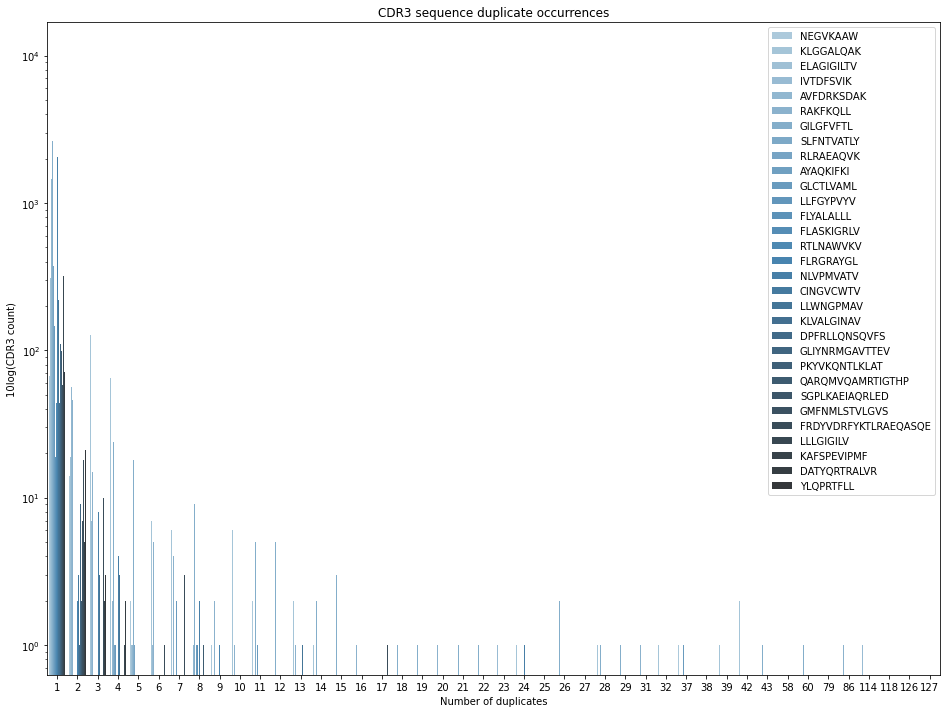

In [189]:
# plot the number of duplicates per CDR3 sequence
counts = []
for peptide in classes: # classes eerder gedefinieerd als 'control', 'EIYKRWII' en 'FLKEKGGL'
    count = vdjdb_data[vdjdb_data['Epitope'] == peptide]['CDR3'].value_counts() # values_counts() zal de unieke waarden tellen
    counts.append(pd.DataFrame({'counts': count, 'peptide': [peptide] * len(count)}))

# opmaak van de plot
plt.figure(figsize=(16, 12))

sns.countplot(x='counts', hue='peptide', data=pd.concat(counts), palette='Blues_d')

plt.yscale('log')

plt.title('CDR3 sequence duplicate occurrences')

plt.xlabel('Number of duplicates')
plt.ylabel('10log(CDR3 count)')

plt.legend(loc='upper right', frameon=True)

plt.savefig('CDR3sequence_distribution.pdf', bbox_inches='tight', dpi=600)
plt.show()
plt.close()

In [205]:
## Zelfde voor de data van McPAS
McPAS_data = pd.read_csv("McPAS_data.csv")

In [208]:
#del McPAS_data['Unnamed: 0']
McPAS_data.head()

,CDR3,Species,Epitope gene,Epitope,MHC A,V,J,Gene
0,CAVTIGFGNVLHCGSGTQVIVLPHIQ,Human,Melan-A/MART-1,EAAGIGILTV,HLA-A*02,TRAV2,TRAJ35,TRA
1,CASGGGADGLTFPYIQF,Human,Melan-A/MART-1,EAAGIGILTV,HLA-A*02,TRAV2,TRAJ45,TRA
2,CAASPPESGGYNKLIF,Human,Melan-A/MART-1,EAAGIGILTV,HLA-A*02,TRAV21,TRAJ4,TRA
3,CAAYYGGSOGNLIF,Human,Melan-A/MART-1,EAAGIGILTV,HLA-A*02,TRAV21,TRAJ42,TRA
4,CAVSRGGGADGLTF,Human,Melan-A/MART-1,EAAGIGILTV,HLA-A*02,TRAV2,TRAJ45,TRA


In [212]:
McPAS_pos = McPAS_data.groupby('Epitope').filter(lambda x: len(x)> 30)

In [214]:
Epitopes = McPAS_pos ['Epitope'].unique()
print (Epitopes) # enkel RPRGEVRFL, KMVAVFYTT, VVLSWAPPV en NLNCCSVPV komen nog niet in vdjdb voor de rest wel

['GLCTLVAML' 'NLVPMVATV' 'KAFSPEVIPMF' 'RPRGEVRFL' 'GILGFVFTL' 'LLWNGPMAV'
 'ELAGIGILTV' 'RFYKTLRAEQASQ' 'KLVALGINAV' 'KMVAVFYTT' 'VVLSWAPPV'
 'NLNCCSVPV']


In [215]:
TRAJ = McPAS_data ['J'].unique()
print (TRAJ) # gebruikt niet de standaard naamgeving


['TRAJ35' 'TRAJ45' 'TRAJ4' 'TRAJ42' 'TRAJ47' 'TRAJ9' 'TRAJ39' 'TRAJ48'
 'TRAJ1' 'TRAJ5-1' 'TRAJ15' nan 'TRAJ2' 'TRAJ5' 'TRAJ49' 'TRAJ54' 'TRAJ21'
 'TRAJ53' 'TRAJ40' 'TRAJ36' 'TRAJ38' 'TRAJ26' 'TRAJ3' 'TRAJ37' 'TRAJ11'
 'TRAJ31' 'TRAJ34' 'TRAJ23' 'TRAJ16' 'TRAJ1-3' 'TRAJ9-1' 'TRAJ16-5'
 'TRAJ1-8' 'TRAJ10-1' 'TRAJ3-2' 'TRAJ9-14' 'TRAJ14-1' 'TRAJ16-1' 'TRAJ33'
 'TRAJ52' 'TRAJ44' 'TRAJ43' 'TRAJ50' 'TRAJ20' 'TRAJ58' 'TRAJ6' 'TRAJ57'
 'TRAJ8' 'TRAJ13' 'TRAJ29' 'TRAJ27' 'TRAJ30' 'TRAJ32' 'TRAJ10' 'TRAJ24'
 'TRAJ7' 'TRAJ28' 'TRAJ56' 'TRAJ37-2' 'TRAJ41' 'TRAJ17' 'TRAJ22' 'TRAJ12'
 'TRAJ4-01' 'TRAJ5-01' 'TRAJ3-01' 'TRAJ1-01' 'TRAJ24:02' 'TRAJ2-01'
 'TRAJ9-01' 'TRAJ6-01' 'TRAJ8-01' 'TRAJ13:02' 'TRAJ49:01' 'TRAJ20:01'
 'TRAJ42:01' 'TRAJ24:01' 'TRAJ21:01' 'TRAJ7:01' 'TRAJ39:01' 'TRAJ36:01'
 'TRAJ54:01' 'TRAJ16:01' 'TRAJ58:01' 'TRAJ18' 'TRAJ53:01' 'TRAJ53:02'
 'TRAJ53:05' 'TRAJ43:01' 'TRAJ2-1' 'TRAJ41:01' 'TRAJ3-1' 'TRAJ34:01'
 'TRAJ31:01' 'TRAJ44:01' 'TRAJ38:01' 'TRAJ17:01' 'TRAJ48:01' 'TRAJ9:01'
 